In [82]:
import os
from glob import glob
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import skimage.exposure
from scipy import signal
from sklearn.datasets import fetch_openml, fetch_lfw_people
from sklearn.model_selection import train_test_split

import cv2 as cv
from PIL import Image, ImageOps

In [83]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

UsageError: Line magic function `%tensorflow_version` not found.


### **Create X and y**

In [84]:
AorC = 'Cathodic'
base_dir = 'C:\\Users\\Na Min An\\Desktop\\Development\\Fluorescence'

data_dir = os.path.join(base_dir, 'data')
fig_dir = os.path.join(os.path.join(base_dir, 'figures'), 'Fig4')

if AorC == 'Anodic':
  PATH = os.path.join(data_dir, 'Fig4_ver01_220908_data099.anodic.frame1048to1748')
elif AorC == 'Cathodic':
  PATH = os.path.join(data_dir, 'Fig4_ver01_220908_data099.cathodic.frame1048to1748')

os.chdir(PATH)

for (i, filename) in enumerate(sorted(glob('*.png'))):
  tmp_X = cv.imread(os.path.join(PATH, filename), cv.IMREAD_GRAYSCALE)

  tmp_X = np.array(tmp_X.astype(np.float32))
  tmp_X = np.expand_dims(tmp_X, axis=0)
  tmp_X /= 255.0

  if i == 0:
    X = tmp_X
    h,  w = X.shape[1], X.shape[2]
  else:
    tmp_X = tmp_X[:, :h, :w]
    X = np.concatenate([X, tmp_X], axis=0)

y = np.array([0] * X.shape[0])
print(X.shape, y.shape)
print(np.unique(y))
print(X.min(), X.max(), y.min(), y.max())

(8, 317, 317) (8,)
[0]
0.0 0.94509804 0 0


### **Choose data**

In [85]:
which_data = 'places' # mnist or lfw_people or places

In [86]:
if which_data != 'places':
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  assert(X_train.shape[0] + X_test.shape[0] == which_data.data.shape[0])
else:
  X_train, y_train = X, y

### **Detect edges**

In [87]:
# rainbow = {0: (211, 90, 107),
#            1: (247, 178, 110),
#            2: (209, 234, 178),
#            3: (133, 204, 181),
#            4: (102, 173, 181),
#            5: (146, 166, 204),
#            6: (84, 114, 175),
#            7: (139, 20, 128)} # pastel

rainbow = {0: (162,20,47),
           1: (217,83,25),
           2: (237,177,32),
           3: (119,172,48),
           4: (77,190,238),
           5: (1,114,189),
           6: (126,47,142),
           7: (162,20,47)} # matlab

In [88]:
np.unique(blur)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  97, 100, 103, 105, 106, 108, 110, 121,
       122, 123, 131], dtype=uint8)

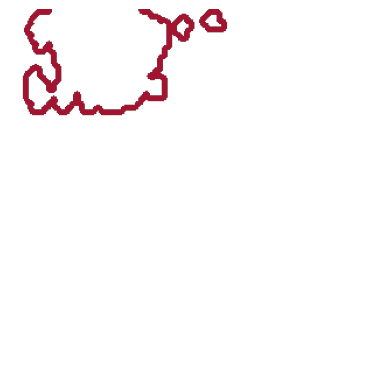

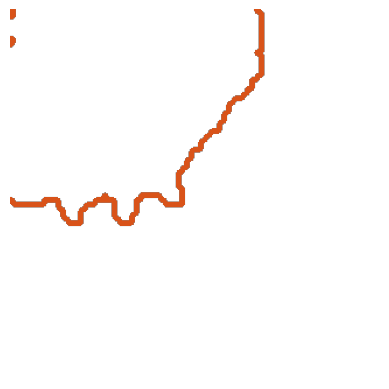

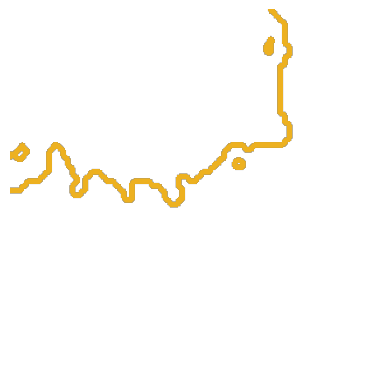

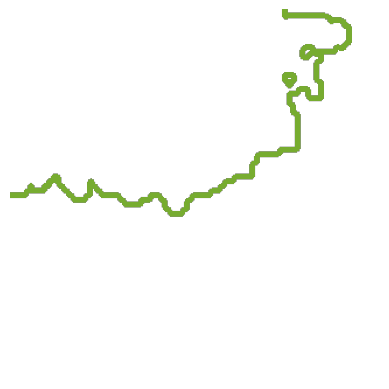

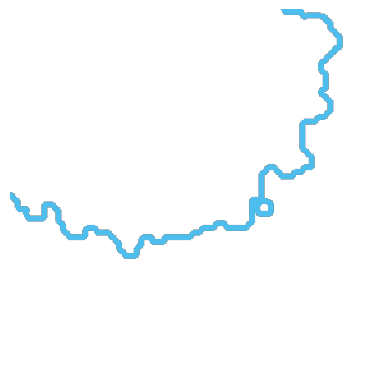

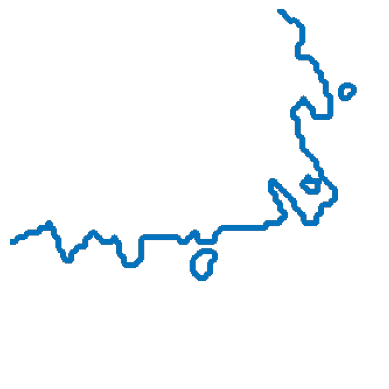

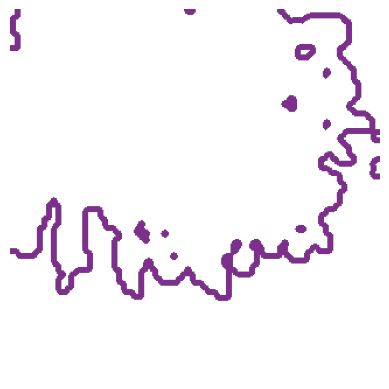

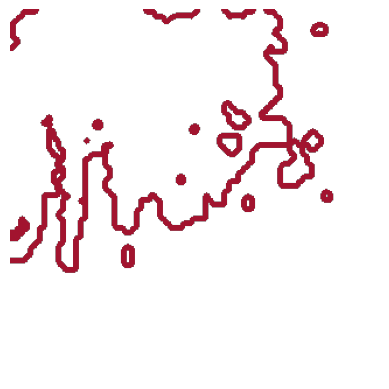

In [91]:
for i in range(X.shape[0]):
  img = X_train[i, :, :] * 255

  # get the outer borderline only
  binary = np.where(img > 0, 255, img) # the most outer boarder

  # edge detect with Canny operator
  binary = np.uint8(binary)
  canny = cv.Canny(binary, 100, 200)

  # make it into binary image
  binary2 = np.where(canny < 128, 0, canny)
  binary2 = np.where(canny >= 128, 255, canny)

  # smooth the edge
  blur = cv.GaussianBlur(binary2, ksize=(0, 0), sigmaX=0.7, sigmaY=0.7, borderType = cv.BORDER_DEFAULT) # 0.7, 1.4

  # make it into binary image
  binary3 = np.where(blur > 0, 255, blur)

  # to make colorful contour lines
  colored = np.expand_dims(binary3, axis=-1)
  colored = np.concatenate([colored, colored, colored], axis=-1)
  
  colored = np.where(colored==(255, 255, 255), rainbow[i], colored)
  colored = colored / 255. # change it to float

  alphas = np.ones((colored.shape[0], colored.shape[1]))
  alphas = np.where(colored[:, :, 0] == 0, 0, alphas)
  alphas = np.expand_dims(alphas, axis=-1)

  colored = np.concatenate([colored, alphas], axis=-1)

  # visualize 
  plt.imshow(colored) 
  plt.axis('off')
  plt.xticks([])
  plt.yticks([])
  plt.show()

  # save the image
  plt.imsave(os.path.join(os.path.join(fig_dir, f'{AorC}'), f'{i}.png'), colored)

In [32]:
binary.shape

(317, 317)

### **Smooth the edges**

In [9]:
os.chdir(os.path.join(fig_dir, f'{AorC}'))

for filename in sorted(glob('*.png')):
    img = cv.imread(filename)
    blur = cv.GaussianBlur(img, (0,0), sigmaX=3, sigmaY=3, borderType = cv.BORDER_DEFAULT)
    result = skimage.exposure.rescale_intensity(blur, in_range=(127.5,255), out_range=(0,255))
    cv.imwrite(f'Smoothed{filename}', result)

In [23]:
np.unique(sobel)

array([0.        , 0.07843137, 0.18431373, 0.63529412, 1.        ])